In [1]:
from os import listdir
from os.path import isdir, join
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa

In [2]:
data_dir='C:/Users/cferr/Documents/4th Year/FYP Data/speech_commands_v0.02'
data_dir_mini='C:/Users/cferr/OneDrive/Documents/4th Year/FYP/Implementation/data/mini_speech_commands/'
keywords = [name for name in listdir(data_dir) if isdir(join(data_dir, name))]
#remove bg noise as it not a keyword
keywords.remove('_background_noise_')
print(keywords)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [47]:
go1 = data_dir+'go/0a9f9af7_nohash_0.wav'
up2=data_dir+'up/0ac15fe9_nohash_0.wav'

#### Using p_s_f

In [48]:
sr,y=wavfile.read(go1)

In [49]:
type(y)

numpy.ndarray

In [50]:
y=y[:15000]

In [51]:
mfccs=mfcc(y, sr)

In [52]:
print('\nMFCC:\nNumber of windows =', mfccs.shape[0])
print('Length of each feature =', mfccs.shape[1])


MFCC:
Number of windows = 84
Length of each feature = 13


Text(0.5, 1.05, 'MFCC')

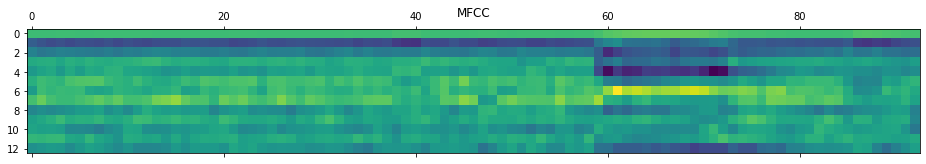

In [29]:
mfccs = mfccs.T
plt.matshow(mfccs)
plt.title('MFCC')

In [18]:
sr,y=wavfile.read(go1)
filterbank_features = logfbank(y, sr)

In [19]:
print('\nFilter bank:\nNumber of windows =', filterbank_features.shape[0])
print('Length of each feature =', filterbank_features.shape[1])


Filter bank:
Number of windows = 84
Length of each feature = 26


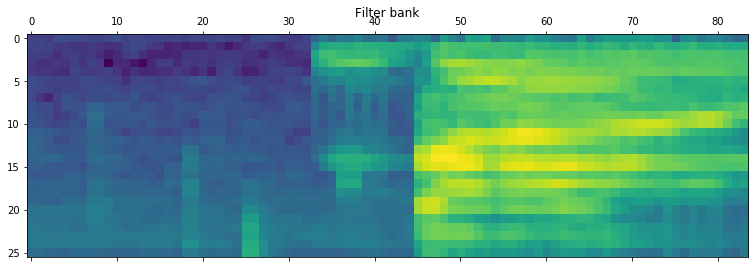

In [20]:
filterbank_features = filterbank_features.T
plt.matshow(filterbank_features)
plt.title('Filter bank')
plt.show()

#### Using librosa

In [39]:

# Load the waveforms samples and convert to mfcc
raw_samples, sample_rate = librosa.load(go1)
mfcc  = librosa.feature.mfcc(y=raw_samples, sr=sample_rate)
# print('Wave duration is %4.2f seconds'+ %(len(raw_samples)/float(sample_rate)))
print(len(raw_samples)/float(sample_rate))

    # Create the network's input training data, X
    # mfcc is organized (feature, sample) but the net needs (sample, feature)
    # X is mfcc reorganized to (sample, feature)
X = np.moveaxis(mfcc, 1, 0)

    # Note that 512 samples is the default 'hop_length' used in calculating 
    # the mfcc so each mfcc spans 512/sample_rate seconds.
mfcc_samples = mfcc.shape[1]
mfcc_span    = 512/float(sample_rate)
print('MFCC calculated duration is %4.2f seconds' %(mfcc_span*mfcc_samples))

    # for 'n' network input samples, calculate the time point where they occur
    # and get the appropriate label index for them.
    # Use +0.5 to get the middle of the mfcc's point in time.


0.8533786848072562
MFCC calculated duration is 0.86 seconds


Text(0.5, 1.05, 'MFCC')

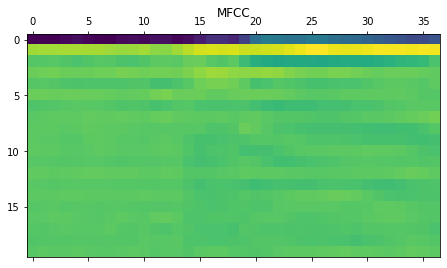

In [53]:
X = X.T
plt.matshow(X)
plt.title('MFCC')

# tuning section

In [13]:
import os
from os.path import isdir, join
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from scipy.io import wavfile
import python_speech_features
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from livelossplot import PlotLossesKeras
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from timeit import default_timer as timer
from IPython.display import clear_output

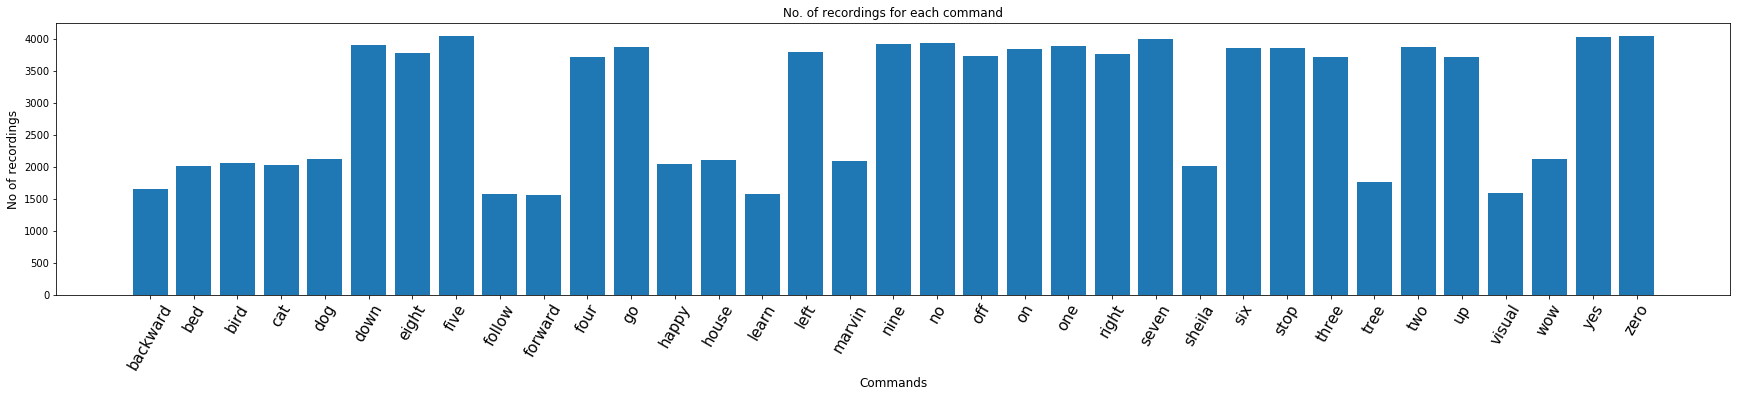

In [4]:
no_of_recordings=[]
for label in keywords:
    waves = [f for f in os.listdir(data_dir + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(keywords))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, keywords, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [5]:
min(no_of_recordings)

1557

we can see that there a number of words with sig less samples than others, therefore will try average out

In [10]:
word2index = {
    # core words
    "backward": 0,
    "bed": 1,
    "bird": 2,
    "cat": 3,
    "dog": 4,
    "down": 5,
    "eight": 6,
    "five": 7,
    "follow": 8,
    "forward": 9,
    "four": 10,
    "go": 11,
    "happy": 12,
    "house": 13,
    "learn": 14,
    "left": 15,
    "marvin": 16,
    "nine": 17,
    "no": 18,
    "off": 19,
    "on":20,
    "one":21,
    "right":22,
    "seven":23,
    "sheila":24,
    "six":25,
    "stop":26,
    "three":27,
    "tree":28,
    "two":29,
    "up":30,
    "visual":31,
    "wow":32,
    "yes":33,
    "zero":34
}

index2word = [word for word in word2index]

In [11]:
len(word2index)

35

In [12]:
num_classes = len(word2index)
num_samples_per_class = 1500
speech_commands_dataset_basepath = Path(data_dir)

samples = []
classes =  []

for word_class in word2index:
    folder = speech_commands_dataset_basepath / word_class # sub-folder for each word
    count = 0
    for file in folder.iterdir(): # iterate over all files in the folder
        # somehow, there are samples which aren't exactly 1 s long in the dataset. ignore those
        if file.stat().st_size == 32044:
            samples.append(file) # store path of sample file
            classes.append(word2index[word_class]) # append word class index to list
            count +=1
            
        if count >= num_samples_per_class:
            break
classes = np.array(classes, dtype=np.int)

In [63]:
def extract_mfcc(filepath):
    samplerate, data = wavfile.read(filepath)
    data = data.astype(np.float)
    # normalize data
    data -= data.mean()
    data /= np.max((data.max(), -data.min()))
    # add gaussian noise
#     data += np.random.normal(loc=0.0, scale=0.025, size=data.shape)
    # compute MFCC coefficients
    features = python_speech_features.mfcc(data, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features.T

In [64]:
feature_shape = extract_mfcc(samples[0]).shape
features = np.empty((len(samples), )+(feature_shape), dtype=np.float)
print("features.shape", features.shape)

print("pre-computing features from audio files...")
with tqdm(total=len(samples)) as pbar:
    for k, sample in enumerate(samples):
        features[k] = wav2feature(sample)
        pbar.update()

features.shape (52274, 13, 99)
pre-computing features from audio files...


In [66]:
features.shape

(52274, 13, 99)

In [67]:
train_data, validation_data, train_classes, validation_classes = train_test_split(features, classes,
                                                                      test_size=0.30, random_state=42, shuffle=True)

In [68]:
train_data = train_data.reshape(train_data.shape[0], 
                          train_data.shape[1], 
                          train_data.shape[2], 
                          1)
validation_data = validation_data.reshape(validation_data.shape[0], 
                      validation_data.shape[1], 
                      validation_data.shape[2], 
                      1)

In [99]:
keras.backend.clear_session() 

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(13, 99, 1)))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')) #try 64 vs 32
model.add(keras.layers.MaxPooling2D(pool_size=(1,2)))#reducing in x dimension by 2
model.add(keras.layers.Dropout(0.25))#check to make sure this is 25 not 75
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
#bottleneck to summarise info
model.add(keras.layers.Conv2D(16, kernel_size=(1,1), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(1, 2)))

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 97, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 46, 64)         18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 46, 16)         1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 23, 16)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 23, 16)         0

In [100]:
sgd = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy() # use Sparse because classes are represented as integers not as one-hot encoding

model.compile(optimizer=sgd, loss=loss_fn, metrics=["accuracy"])

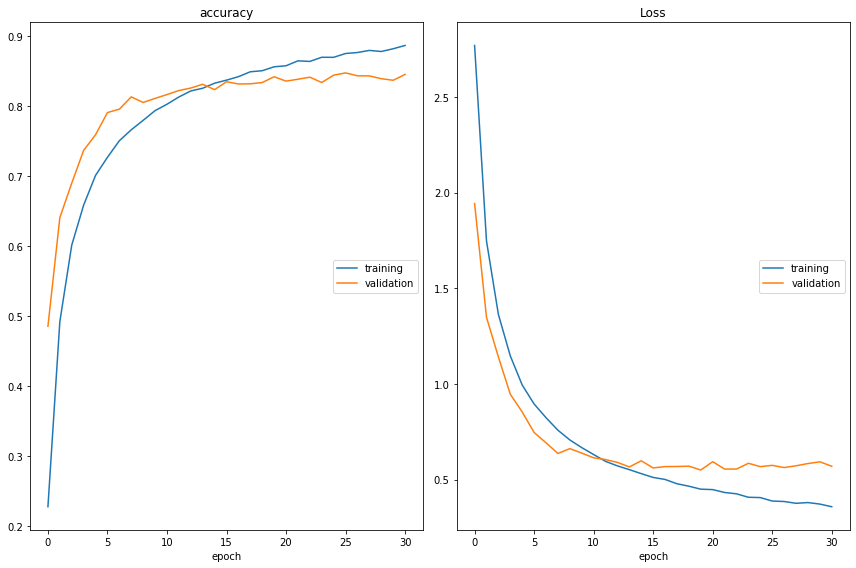

accuracy
	training         	 (min:    0.228, max:    0.886, cur:    0.886)
	validation       	 (min:    0.485, max:    0.847, cur:    0.845)
Loss
	training         	 (min:    0.358, max:    2.769, cur:    0.358)
	validation       	 (min:    0.550, max:    1.943, cur:    0.570)


In [101]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
plt.close()

history = model.fit(train_data, 
                    train_classes, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(validation_data, validation_classes),
                    callbacks=[PlotLossesKeras(), early_stopping])

In [102]:
model.save(datetime.now().strftime("%d_%m_%Y__%H_%M")+".h5")

In [103]:
sample_file = str(data_dir)+'/'+'no/01bb6a2a_nohash_0.wav'

features = wav2feature(sample_file)
features=features.reshape(1,features.shape[0], 
                          features.shape[1],  
                          1)
prediction = model(features)

# for spectrogram, label in sample_ds.batch(1):
#   prediction = model(spectrogram)
#   plt.bar(commands, tf.nn.softmax(prediction[0]))
#   plt.title(f'Predictions for "{commands[label[0]]}"')
#   plt.show()

In [104]:
prediction = model.predict(features).reshape((35, ))

In [105]:
prediction /= prediction.sum()

# print the 3 candidates with highest probability
prediction_sorted_indices = prediction.argsort()
print("candidates:\n-----------------------------")
for k in range(3):
    i = int(prediction_sorted_indices[-1-k])
    print("%d.)\t%s\t:\t%2.1f%%" % (k+1, index2word[i], prediction[i]*100))

candidates:
-----------------------------
1.)	no	:	93.6%
2.)	go	:	3.8%
3.)	learn	:	1.6%
